In [1]:
#notebook to show how CNN classifiers can be used to predict aspects of the building sales
import matplotlib.pyplot as plt
import matplotlib.dates
import numpy as np
import pandas as pd
import tensorflow as tf
from geopy.geocoders import Nominatim
import datetime
import nycsales as nyc
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

#join 2015 data with the longitude and latitutde data from building shapefile
#fname = 'data/2015_brooklyn.csv'
#bk = pd.read_csv(fname,sep = ',')
#shapecsvname = 'data/BuildingFootprints_augmented.csv'
#bknew = nyc.join_latlong(bk,shapecsvname)

#a previously saved version is here, to keep large files out of the git repo
bknew = pd.read_csv('data/bk15_augmented.csv',sep = ',')


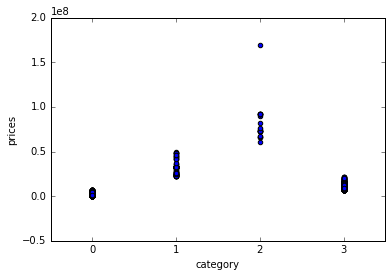

In [2]:
#First classifier: predict price category based on geographic and building features
## try and prep data to run through a deep neural net classifier to predict 
#"category" of cheap, medium cheap, expensive, real expensive prices

#convert saledate to datetime
bknew['SALE DATE'] =pd.to_datetime(bknew['SALE DATE'])

#mask to clean data
test1 = bknew['SALE PRICE'] > 0.0 
test2 = bknew['GROSS SQUARE FEET'] > 0.0
test3 = ~np.isnan(bknew['SALE PRICE'])
test4 = ~np.isnan(bknew['GROSS SQUARE FEET'])
test = test1 & test2 & test3 & test4

#paramlist = ['RESIDENTIAL UNITS','COMMERCIAL UNITS','TOTAL UNITS','LAND SQUARE FEET',
#                    'GROSS SQUARE FEET','YEAR BUILT','SALE DATE','long','lat']

paramlist = ['RESIDENTIAL UNITS','COMMERCIAL UNITS','TOTAL UNITS','LAND SQUARE FEET',
                    'GROSS SQUARE FEET','YEAR BUILT','long','lat']
class_dat = bknew.loc[test,paramlist]
class_dat = class_dat.rename(index=str, columns={"RESIDENTIAL UNITS": "resunits", 
                                     "COMMERCIAL UNITS": "communits",
                                    "TOTAL UNITS":"totalunits",
                                    "LAND SQUARE FEET":"landsquarefeet",
                                    "GROSS SQUARE FEET":"grosssquarefeet",
                                    "YEAR BUILT":"yearbuilt",
                                    "SALE DATE":"saledate"})
#create labels. bin prices into 5 categories using k-means
nclasses = 4
prices_kmeans = bknew.loc[test,'SALE PRICE']
kmeans = KMeans(n_clusters=nclasses, random_state=0).fit(np.array(prices_kmeans).reshape(-1, 1))
class_labels = pd.Series(kmeans.labels_)

#check and see what the categories are like. if they overlap. they do, especially 3
plt.scatter(class_labels,prices_kmeans)
plt.xlabel('category')
plt.ylabel('prices')
plt.xticks([0,1,2,3])
plt.show()


#partition data into 80% training and 20% testing.
train_dat, test_dat, train_labels, test_labels = train_test_split(
    class_dat, class_labels, test_size=0.2, random_state=42)



In [3]:
#Training setup

batchsize = 500 #number of trials per training batch
nsteps = 1000

# Feature columns describe how to use the input.
my_feature_columns = []
for key in train_dat.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
    
#The trainign input function
def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)

    # Return the dataset.
    return dataset

input_fn=lambda:train_input_fn(train_dat, train_labels,
                                             batchsize)

# Build 6 hidden layer DNN with 10, 10 units respectively.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # 6 hidden layers of 10 nodes each.
    hidden_units=[10,10,10,10,10,10],
    # The model must choose between 3 classes.
    n_classes=nclasses)

# # Train the Model.
classifier.train(input_fn,steps=nsteps)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x104011210>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/var/folders/_x/hjcw_nn146jgqk4lp69ghtxr0000gn/T/tmpuR8DaA', '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/_x/hjcw_nn146jgqk4lp69ghtxr0000g

In [4]:
#Evaluate the testing data

#input function to prepare data for evluation phase
def eval_input_fn(features, labels, batch_size):
    """An input function for evaluation or prediction"""
    features=dict(features)
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)

    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    # Return the dataset.
    return dataset


# Evaluate the model, check accuracy of training data
print('evaluation of training data-------------')

eval_result = classifier.evaluate(
   input_fn=lambda:eval_input_fn(train_dat, train_labels,
                                batchsize))

#now check performance for testing data
print('evaluation of testing data---------------')
eval_result = classifier.evaluate(
   input_fn=lambda:eval_input_fn(test_dat, test_labels,
                                batchsize))



evaluation of training data-------------
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-10-22:42:59
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/_x/hjcw_nn146jgqk4lp69ghtxr0000gn/T/tmpuR8DaA/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-10-22:43:00
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.9649606, average_loss = 0.11479951, global_step = 1000, loss = 57.33518
evaluation of testing data---------------
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-10-22:43:01
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/_x/hjcw_nn146jgqk4lp69ghtxr0000gn/T/tmpuR8DaA/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running 